In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 50)

import os
# Use this to see how much memory the dataframes use
from sys import getsizeof

from vivarium_research_prl.utils import sizemb, MappingViaAttributes
from vivarium_research_prl import datatypes
from vivarium_research_prl.noise import corruption, fake_names, noisify
from vivarium_research_prl.find_kids import datasets, noisify_data

!date
!whoami
!uname -a
!pwd

Thu 23 Mar 2023 05:22:08 PM PDT
ndbs
Linux int-slurm-sarchive-p0011 5.4.0-135-generic #152-Ubuntu SMP Wed Nov 23 20:19:22 UTC 2022 x86_64 x86_64 x86_64 GNU/Linux
/mnt/share/code/ndbs/vivarium_research_prl/model_validation


In [33]:
%load_ext autoreload
%autoreload 2

In [37]:
from vivarium_research_prl.utils import MappingViaAttributes

In [38]:
utils.MappingViaAttributes

vivarium_research_prl.utils.MappingViaAttributes

# Find data

```
/ihme/scratch/users/zmbc/vivarium_results/united_states_of_america/2023_03_20_11_09_48/final_results/2023_03_20_12_31_44
```

In [11]:
project_output_dir = \
    '/ihme/scratch/users/zmbc/vivarium_results'
output_subdir = (
    '/united_states_of_america/2023_03_20_11_09_48'
    '/final_results/2023_03_20_12_31_44'
)
output_dir = f'{project_output_dir}{output_subdir}'

!ls -halt $output_dir

total 40K
drwxrwxr-x  8 zmbc Domain Users 3.5K Mar 20 12:35 ..
drwxrwxr-x  2 zmbc Domain Users  512 Mar 20 12:35 tax_dependents_observer
drwxrwxr-x 10 zmbc Domain Users 4.0K Mar 20 12:35 .
drwxrwxr-x  2 zmbc Domain Users  512 Mar 20 12:35 tax_1040_observer
drwxrwxr-x  2 zmbc Domain Users  512 Mar 20 12:35 tax_w2_observer
drwxrwxr-x  2 zmbc Domain Users  512 Mar 20 12:35 social_security_observer
drwxrwxr-x  2 zmbc Domain Users  512 Mar 20 12:35 wic_observer
drwxrwxr-x  2 zmbc Domain Users  512 Mar 20 12:35 household_survey_observer_cps
drwxrwxr-x  2 zmbc Domain Users  512 Mar 20 12:35 household_survey_observer_acs
drwxrwxr-x  2 zmbc Domain Users  512 Mar 20 12:35 decennial_census_observer


# Load all data using `os.walk`

In [12]:
walker = os.walk(output_dir)
next(walker)

('/ihme/scratch/users/zmbc/vivarium_results/united_states_of_america/2023_03_20_11_09_48/final_results/2023_03_20_12_31_44',
 ['decennial_census_observer',
  'tax_1040_observer',
  'wic_observer',
  'social_security_observer',
  'tax_dependents_observer',
  'household_survey_observer_cps',
  'tax_w2_observer',
  'household_survey_observer_acs'],
 [])

In [13]:
next(walker)

('/ihme/scratch/users/zmbc/vivarium_results/united_states_of_america/2023_03_20_11_09_48/final_results/2023_03_20_12_31_44/decennial_census_observer',
 [],
 ['decennial_census_observer.csv.bz2'])

In [16]:
s = '/ihme/scratch/users/zmbc/vivarium_results//united_states_of_america/2023_03_20_11_09_48/final_results/2023_03_20_12_31_44/decennial_census_observer'
s[s.rindex('/')+1:]



'decennial_census_observer'

In [6]:
l = []

In [7]:
l.append(3)
l

[3]

In [25]:
%%time
dfs = {}
nrows = None
ext = '.csv.bz2'
for dirpath, dirnames, filenames in os.walk(output_dir):
    observer_name = dirpath[dirpath.rindex('/')+1:]
    print("="*50)
    print("Loading data from", observer_name, "\n")
    shards = []
    for filename in filenames:
        if filename.endswith(ext):
            filename_root = filename[:-len(ext)]
            filepath = os.path.join(dirpath, filename)
            print("Loading shard", filename)
            %time shards.append(pd.read_csv(filepath, nrows=nrows))
    if shards:
        print("\nConcatenating data for ", observer_name)
        %time df = pd.concat(shards)
        dfs[observer_name] = df
    print("\n")
dfs.keys()

Loading data from 2023_03_20_12_31_44 



Loading data from decennial_census_observer 

Loading shard decennial_census_observer.csv.bz2
CPU times: user 143 ms, sys: 3.09 ms, total: 146 ms
Wall time: 146 ms

Concatenating data for  decennial_census_observer
CPU times: user 1.83 ms, sys: 0 ns, total: 1.83 ms
Wall time: 1.83 ms


Loading data from tax_1040_observer 

Loading shard tax_1040_observer.csv.bz2
CPU times: user 571 ms, sys: 35.7 ms, total: 607 ms
Wall time: 610 ms

Concatenating data for  tax_1040_observer
CPU times: user 9.04 ms, sys: 95 µs, total: 9.13 ms
Wall time: 8.56 ms


Loading data from wic_observer 

Loading shard wic_observer.csv.bz2
CPU times: user 13.8 ms, sys: 0 ns, total: 13.8 ms
Wall time: 14.2 ms

Concatenating data for  wic_observer
CPU times: user 498 µs, sys: 0 ns, total: 498 µs
Wall time: 502 µs


Loading data from social_security_observer 

Loading shard social_security_observer.csv.bz2
CPU times: user 60.1 ms, sys: 0 ns, total: 60.1 ms
Wall time: 60.4 ms


dict_keys(['decennial_census_observer', 'tax_1040_observer', 'wic_observer', 'social_security_observer', 'tax_dependents_observer', 'household_survey_observer_cps', 'tax_w2_observer', 'household_survey_observer_acs'])

In [26]:
dfs['decennial_census_observer']

,middle_initial,state,age,housing_type,city,date_of_birth,simulant_id,unit_number,guardian_1,relation_to_household_head,sex,zipcode,race_ethnicity,last_name,year,street_number,street_name,guardian_2,first_name
0,M,USA,76.024932,Standard,Anytown,1944-03-23,0_4,NaN,0_-1,Reference person,Female,90210,Black,Shipp,2020,1312,commonwealth avnue,0_-1,Maureen
1,N,USA,69.075260,Standard,Anytown,1951-03-05,0_5,NaN,0_-1,Opp-sex spouse,Male,90210,Black,Shipp,2020,1312,commonwealth avnue,0_-1,Richard
2,C,USA,66.661179,Standard,Anytown,1953-08-03,0_2464,NaN,0_-1,Reference person,Female,90210,Black,Holt,2020,46,bancroft st,0_-1,Darlene
3,S,USA,42.860033,Standard,Anytown,1977-05-22,0_3558,NaN,0_-1,Reference person,Female,90210,Black,Holt,2020,9112,janis ne,0_-1,Tabatha
4,M,USA,25.293532,Standard,Anytown,1994-12-16,0_3559,NaN,0_-1,Biological child,Female,90210,Black,Holt,2020,9112,janis ne,0_-1,Alice
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19949,S,USA,66.493182,Standard,Anytown,1963-09-21,0_17995,NaN,0_-1,Reference person,Male,90210,White,Wasser,2030,5700,n cr 400 e,0_-1,John
19950,K,USA,77.426139,Standard,Anytown,1952-10-15,0_18073,NaN,0_-1,Reference person,Male,90210,Black,Hughes,2030,21,mammoth springs dr,0_-1,Clyde
19951,C,USA,2.432617,Standard,Anytown,2027-11-11,0_22588,NaN,0_14366,Reference person,Female,90210,Black,Walker,2030,8728,high pine meadows r,0_-1,Stephanie
19952,D,USA,23.517320,Standard,Anytown,2006-10-10,0_22759,NaN,0_-1,Reference person,Male,90210,White,Foster,2030,1900,ranch loop,0_-1,Austin


In [28]:
dfs['tax_w2_observer']

,middle_initial,mailing_address_unit_number,ssn,mailing_address_state,employer_street_number,employer_street_name,age,date_of_birth,simulant_id,employer_id,...,mailing_address_city,last_name,employer_zipcode,employer_unit_number,is_w2,mailing_address_po_box,mailing_address_street_number,employer_state,tax_year,first_name
0,M,NaN,828-99-4653,USA,NaN,stoney crk cir,76.714870,1944-03-23,0_4,1383395,...,Anytown,Shipp,2420.0,NaN,True,0,1312,MA,2020,Maureen
1,N,NaN,885-38-0858,USA,264-12,hallmont dr,69.765199,1951-03-05,0_5,79783,...,Anytown,Shipp,32168.0,NaN,True,0,1312,FL,2020,Richard
2,C,NaN,584-19-7087,USA,NaN,34th st s,67.351117,1953-08-03,0_2464,752669,...,Anytown,Holt,77536.0,NaN,True,0,46,TX,2020,Darlene
3,S,NaN,813-32-2963,USA,1007,e ivy st,43.549972,1977-05-22,0_3558,429922,...,Anytown,Holt,55327.0,NaN,True,0,9112,MN,2020,Tabatha
4,S,NaN,813-32-2963,USA,230,brickyard rd,43.549972,1977-05-22,0_3558,1461471,...,Anytown,Holt,4064.0,unit # 15,True,0,9112,ME,2020,Tabatha
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93770,C,NaN,796-80-2013,USA,1472,plaza del amo,25.955583,2004-01-12,0_12671,1244793,...,Anytown,Rubio,78877.0,NaN,True,0,2569,TX,2029,Emily
93771,C,NaN,796-80-2013,USA,10035,ne basket flat rd,25.955583,2004-01-12,0_12671,1679160,...,Anytown,Rubio,6489.0,NaN,True,0,2569,CT,2029,Emily
93772,K,NaN,105-49-3492,USA,27800,sw 171st ave,77.196160,1952-10-15,0_18073,318759,...,Anytown,Hughes,35643.0,NaN,True,0,21,AL,2029,Clyde
93773,K,NaN,105-49-3492,USA,5134,will duke rd,77.196160,1952-10-15,0_18073,633346,...,Anytown,Hughes,28540.0,NaN,True,0,21,NC,2029,Clyde


In [29]:
dfs['household_survey_observer_acs']

,middle_initial,household_id,state,age,housing_type,city,date_of_birth,simulant_id,unit_number,guardian_1,sex,zipcode,last_name,street_number,survey_date,street_name,guardian_2,first_name
0,R,0_7661,USA,48.866912,Standard,Anytown,1971-05-20,0_18951,NaN,0_-1,Male,90210,Gandy,5.0,2020-04-29,nw 18th pl,0_-1,Curtis
1,C,0_7661,USA,43.998857,Standard,Anytown,1976-04-01,0_18952,NaN,0_-1,Female,90210,Gandy,5.0,2020-04-29,nw 18th pl,0_-1,Patricia
2,J,0_7661,USA,11.528861,Standard,Anytown,2008-09-20,0_18953,NaN,0_18951,Male,90210,Gandy,5.0,2020-04-29,nw 18th pl,0_18952,Ashton
3,C,0_7661,USA,14.777634,Standard,Anytown,2005-06-21,0_18954,NaN,0_-1,Male,90210,Pratt,5.0,2020-04-29,nw 18th pl,0_-1,Joshua
4,I,0_4653,USA,66.865289,Standard,Anytown,1953-07-15,0_11498,NaN,0_-1,Female,90210,Miller,4501.0,2020-06-24,brown e end rd,0_-1,Joan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,C,0_4258,USA,60.376014,Standard,Anytown,1969-07-14,0_10501,NaN,0_-1,Female,90210,Herman,NaN,2029-12-26,valencia ave,0_-1,Renee
138,C,0_4258,USA,61.356419,Standard,Anytown,1968-07-21,0_10502,NaN,0_-1,Male,90210,Herman,NaN,2029-12-26,valencia ave,0_-1,Ricky
139,C,0_4529,USA,64.322824,Standard,Anytown,1965-08-30,0_11185,NaN,0_-1,Female,90210,Larsen,5309.0,2030-01-23,westport pkwy,0_-1,Dee
140,B,0_4313,USA,35.796840,Standard,Anytown,1994-06-02,0_6599,NaN,0_-1,Male,90210,Bracy,30419.0,2030-04-17,w capitol dr,0_-1,David


# Create a convenience mapping to access dataframes with tab completion

In [39]:
data = MappingViaAttributes(dfs)
data.keys()

KeysView(<vivarium_research_prl.utils.MappingViaAttributes object at 0x7fa3709800d0>)

In [42]:
# see how much memory all dataframes take up
sum(map(sizemb, data.values()))

261.398134

In [40]:
list(data.keys())

['decennial_census_observer',
 'tax_1040_observer',
 'wic_observer',
 'social_security_observer',
 'tax_dependents_observer',
 'household_survey_observer_cps',
 'tax_w2_observer',
 'household_survey_observer_acs']

In [41]:
data.household_survey_observer_acs

,middle_initial,household_id,state,age,housing_type,city,date_of_birth,simulant_id,unit_number,guardian_1,sex,zipcode,last_name,street_number,survey_date,street_name,guardian_2,first_name
0,R,0_7661,USA,48.866912,Standard,Anytown,1971-05-20,0_18951,NaN,0_-1,Male,90210,Gandy,5.0,2020-04-29,nw 18th pl,0_-1,Curtis
1,C,0_7661,USA,43.998857,Standard,Anytown,1976-04-01,0_18952,NaN,0_-1,Female,90210,Gandy,5.0,2020-04-29,nw 18th pl,0_-1,Patricia
2,J,0_7661,USA,11.528861,Standard,Anytown,2008-09-20,0_18953,NaN,0_18951,Male,90210,Gandy,5.0,2020-04-29,nw 18th pl,0_18952,Ashton
3,C,0_7661,USA,14.777634,Standard,Anytown,2005-06-21,0_18954,NaN,0_-1,Male,90210,Pratt,5.0,2020-04-29,nw 18th pl,0_-1,Joshua
4,I,0_4653,USA,66.865289,Standard,Anytown,1953-07-15,0_11498,NaN,0_-1,Female,90210,Miller,4501.0,2020-06-24,brown e end rd,0_-1,Joan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,C,0_4258,USA,60.376014,Standard,Anytown,1969-07-14,0_10501,NaN,0_-1,Female,90210,Herman,NaN,2029-12-26,valencia ave,0_-1,Renee
138,C,0_4258,USA,61.356419,Standard,Anytown,1968-07-21,0_10502,NaN,0_-1,Male,90210,Herman,NaN,2029-12-26,valencia ave,0_-1,Ricky
139,C,0_4529,USA,64.322824,Standard,Anytown,1965-08-30,0_11185,NaN,0_-1,Female,90210,Larsen,5309.0,2030-01-23,westport pkwy,0_-1,Dee
140,B,0_4313,USA,35.796840,Standard,Anytown,1994-06-02,0_6599,NaN,0_-1,Male,90210,Bracy,30419.0,2030-04-17,w capitol dr,0_-1,David


In [43]:
data.household_survey_observer_acs.dtypes

middle_initial     object
household_id       object
state              object
age               float64
housing_type       object
city               object
date_of_birth      object
simulant_id        object
unit_number        object
guardian_1         object
sex                object
zipcode             int64
last_name          object
street_number     float64
survey_date        object
street_name        object
guardian_2         object
first_name         object
dtype: object

In [54]:
acs_surveys_by_date = data.household_survey_observer_acs.survey_date.value_counts(sort=False)
acs_surveys_by_date

2020-04-29    4
2020-06-24    2
2020-08-19    1
2020-09-16    1
2020-10-14    1
             ..
2029-08-08    4
2029-09-05    1
2029-12-26    2
2030-01-23    1
2030-04-17    2
Name: survey_date, Length: 69, dtype: int64

<AxesSubplot: >

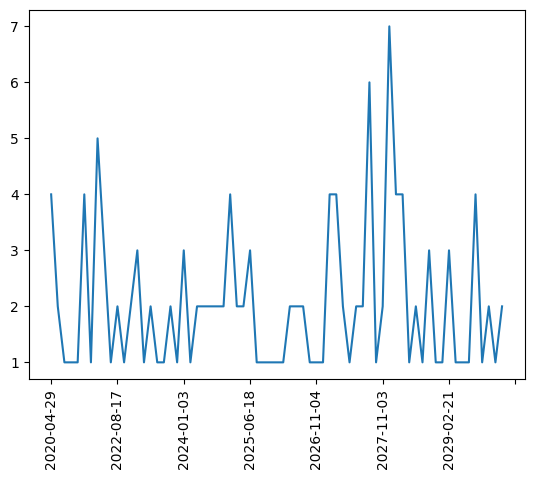

In [56]:
acs_surveys_by_date.plot(rot=90)

In [59]:
acs_survey_years = data.household_survey_observer_acs.survey_date.astype('datetime64').dt.year
acs_survey_years

0      2020
1      2020
2      2020
3      2020
4      2020
       ... 
137    2029
138    2029
139    2030
140    2030
141    2030
Name: survey_date, Length: 142, dtype: int64

<AxesSubplot: >

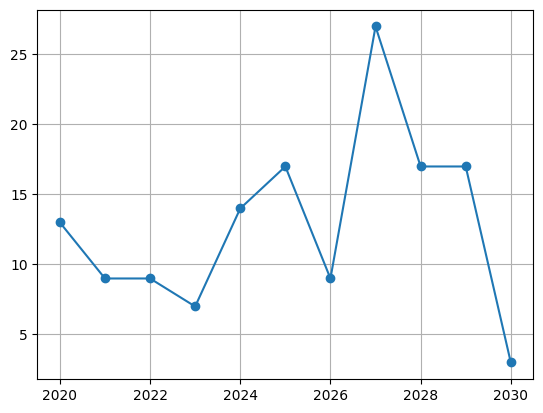

In [67]:
acs_survey_years.value_counts().sort_index().plot(marker='o', grid=True)

In [60]:
data.household_survey_observer_acs.loc[acs_survey_years==2020]

,middle_initial,household_id,state,age,housing_type,city,date_of_birth,simulant_id,unit_number,guardian_1,sex,zipcode,last_name,street_number,survey_date,street_name,guardian_2,first_name
0,R,0_7661,USA,48.866912,Standard,Anytown,1971-05-20,0_18951,NaN,0_-1,Male,90210,Gandy,5.0,2020-04-29,nw 18th pl,0_-1,Curtis
1,C,0_7661,USA,43.998857,Standard,Anytown,1976-04-01,0_18952,NaN,0_-1,Female,90210,Gandy,5.0,2020-04-29,nw 18th pl,0_-1,Patricia
2,J,0_7661,USA,11.528861,Standard,Anytown,2008-09-20,0_18953,NaN,0_18951,Male,90210,Gandy,5.0,2020-04-29,nw 18th pl,0_18952,Ashton
3,C,0_7661,USA,14.777634,Standard,Anytown,2005-06-21,0_18954,NaN,0_-1,Male,90210,Pratt,5.0,2020-04-29,nw 18th pl,0_-1,Joshua
4,I,0_4653,USA,66.865289,Standard,Anytown,1953-07-15,0_11498,NaN,0_-1,Female,90210,Miller,4501.0,2020-06-24,brown e end rd,0_-1,Joan
5,R,0_4653,USA,67.847648,Standard,Anytown,1952-07-22,0_11499,NaN,0_-1,Male,90210,Miller,4501.0,2020-06-24,brown e end rd,0_-1,Kenneth
6,F,0_1410,USA,87.159258,Standard,Anytown,1933-05-25,0_3457,NaN,0_-1,Female,90210,Bratic,56669.0,2020-08-19,citrus tower blvd,0_-1,Shirley
7,D,0_6241,USA,61.854806,Standard,Anytown,1958-10-12,0_15380,NaN,0_-1,Male,90210,Mitchell,558.0,2020-09-16,22nd ave,0_-1,Richard
8,G,0_5568,USA,26.137795,Standard,Anytown,1994-07-28,0_13702,apt 3,0_-1,Female,90210,Parks Kirkpatrick,601.0,2020-10-14,12th ave,0_-1,Jamie
9,D,0_1618,USA,58.755791,Standard,Anytown,1962-02-08,0_3996,NaN,0_-1,Male,90210,Clark,31297.0,2020-12-09,e 22nd st s,0_-1,Robert


In [68]:
data.household_survey_observer_acs.loc[acs_survey_years==2027]

,middle_initial,household_id,state,age,housing_type,city,date_of_birth,simulant_id,unit_number,guardian_1,sex,zipcode,last_name,street_number,survey_date,street_name,guardian_2,first_name
78,L,0_2864,USA,19.852137,Standard,Anytown,2007-02-22,0_242,NaN,0_240,Female,90210,Martin,5606.0,2027-01-27,camas ave ne,0_241,Marissa
79,S,0_2864,USA,56.125135,Standard,Anytown,1970-11-14,0_7110,NaN,0_-1,Male,90210,Brown,5606.0,2027-01-27,camas ave ne,0_-1,Jeffrey
80,J,0_2864,USA,49.106914,Standard,Anytown,1977-11-21,0_7111,NaN,0_-1,Female,90210,Brown,5606.0,2027-01-27,camas ave ne,0_-1,Christina
81,Z,0_2864,USA,19.425159,Standard,Anytown,2007-07-28,0_7112,NaN,0_7110,Male,90210,Brown,5606.0,2027-01-27,camas ave ne,0_7111,Terry
86,J,0_2418,USA,48.354998,Standard,Anytown,1978-09-19,0_17193,NaN,0_-1,Female,90210,Chavez,3608.0,2027-02-24,w portobello ave,0_-1,Julia
87,R,0_2418,USA,31.184827,Standard,Anytown,1995-12-19,0_21475,NaN,0_-1,Female,90210,Dege,3608.0,2027-02-24,w portobello ave,0_-1,Jaime
88,C,0_9560,USA,32.539618,Standard,Anytown,1994-10-06,0_4778,NaN,0_-1,Female,90210,Rogers,1918.0,2027-05-19,cloverleaf lp,0_-1,Brittany
89,J,0_2236,USA,36.742401,Standard,Anytown,1990-08-21,0_5538,NaN,0_-1,Male,90210,Thornhill,7452.0,2027-06-16,e flamingo dr,0_-1,Everette
90,D,0_2236,USA,35.278393,Standard,Anytown,1992-02-07,0_7257,NaN,0_-1,Male,90210,Jimenez Snyder,7452.0,2027-06-16,e flamingo dr,0_-1,Jared
91,J,0_395,USA,58.423783,Standard,Anytown,1969-01-12,0_951,trlr 53,0_-1,Female,90210,Wilson,3631.0,2027-07-14,tapley avenue,0_-1,Tiffany
